, vmin = 0, vmax = 10# Salinity budget on the shelf

"How does the freshwater budget, and its components, integrated over the shelf change? There will be changes due to the input salinity of the basal melt, changing salinity restoring, changing sea ice formation/melt, other air-sea FW fluxes (evap), and cross-slope transports of fresh/salty waters."

Diags:
`salt`

`sfc_salt_flux_restore`

`sfc_hflux_from_runoff`

`sfc_salt_flux_ice`

`sfc_hflux_pme` (?)

`frazil_3d_int_z` (?)

`pme_river`



In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client


In [2]:
client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41753,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:39759,Total threads: 4
Dashboard: /proxy/44235/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40857,


In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
#session_name = '/g/data/v45/akm157/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

# temperature of meltwater using Gade line:
basal = 'accessom2-GPC015'
iceberg = 'accessom2-GPC017'


In [4]:
expt = basal
session = basal_melt_session

geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)


## Salinity Change
These are for ONE YEAR! 

In [15]:
# salinity change from restarts

# copy from heat budget notebook (Adele)

# heat content change:
# We need to calculate this from snapshots from the restarts.

salt_dummy = cc.querying.getvar(control, 'salt', master_session, n=1,frequency='1 monthly')

# note I had to collate these restarts first:
filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_temp_salt.res.nc'
restart1t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_init = restart1t.salt[0,...]
# fix coords:
salt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_init = salt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_init = salt_init.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_thickness.res.nc'
restart1z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_init = restart1z.rho_dzt[0,...]
# fix coords:
dzt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_init = dzt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_init = dzt_init.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart1015/ocean/ocean_temp_salt.res.nc'
restart2t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_end = restart2t.salt[0,...]
# fix coords:
salt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_end = salt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_end = salt_end.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart1015/ocean/ocean_thickness.res.nc'
restart2z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_end = restart2z.rho_dzt[0,...]
# fix coords:
dzt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_end = dzt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_end = dzt_end.drop_vars('Time')


In [16]:
# compute salt content change:

# J / kg / degC
c_p = 3992.1
rho0 = 1035.0
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

# there is a factor of rho_0 in dzt here:
salt_content_change = (1/rho0*((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area).sum()

print('Net salt content change over this period =',salt_content_change.values/1e12,'x 10^12 g/kg m^3')

Net salt content change over this period = -0.49483679296248356 x 10^12 g/kg m^3


Now repeat for basal perturbation

In [17]:
# salinity change from restarts

# copy from heat budget notebook (Adele)

# heat content change:
# We need to calculate this from snapshots from the restarts.

salt_dummy = cc.querying.getvar(basal, 'salt', basal_melt_session, n=1,frequency='1 monthly')

# use same first restarts as control:
filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_temp_salt.res.nc'
restart1t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_init = restart1t.salt[0,...]
# fix coords:
salt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_init = salt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_init = salt_init.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_thickness.res.nc'
restart1z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_init = restart1z.rho_dzt[0,...]
# fix coords:
dzt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_init = dzt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_init = dzt_init.drop_vars('Time')

#basal restart
filepath = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/'+basal+'/restarts/restart1002/ocean/ocean_temp_salt.res.nc'
restart2t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_end = restart2t.salt[0,...]
# fix coords:
salt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_end = salt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_end = salt_end.drop_vars('Time')

filepath = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/'+basal+'/restarts/restart1002/ocean/ocean_thickness.res.nc'
restart2z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_end = restart2z.rho_dzt[0,...]
# fix coords:
dzt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_end = dzt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_end = dzt_end.drop_vars('Time')



In [18]:
# compute salt content change:

# J / kg / degC
c_p = 3992.1
rho0 = 1035.0
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

# there is a factor of rho_0 in dzt here:
salt_content_change = (1/rho0*((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area).sum()

print('Net salt content change over this period =',salt_content_change.values/1e12,'x 10^12 g/kg m^3')

Net salt content change over this period = -52.31679257402289 x 10^12 g/kg m^3


These are over the whole ocean. Basal's is much bigger. Also this is for **ONE YEAR**, 2150-01-01 to 2151-01-01

## Masking shelf

Need to mask just the shelf (<1000m), but parts of shelf have depth > 1000m so can't just do a .where()


use from https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb


In [5]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map


In [6]:
ht = cc.querying.getvar(expt,'ht', session, n=1) 
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

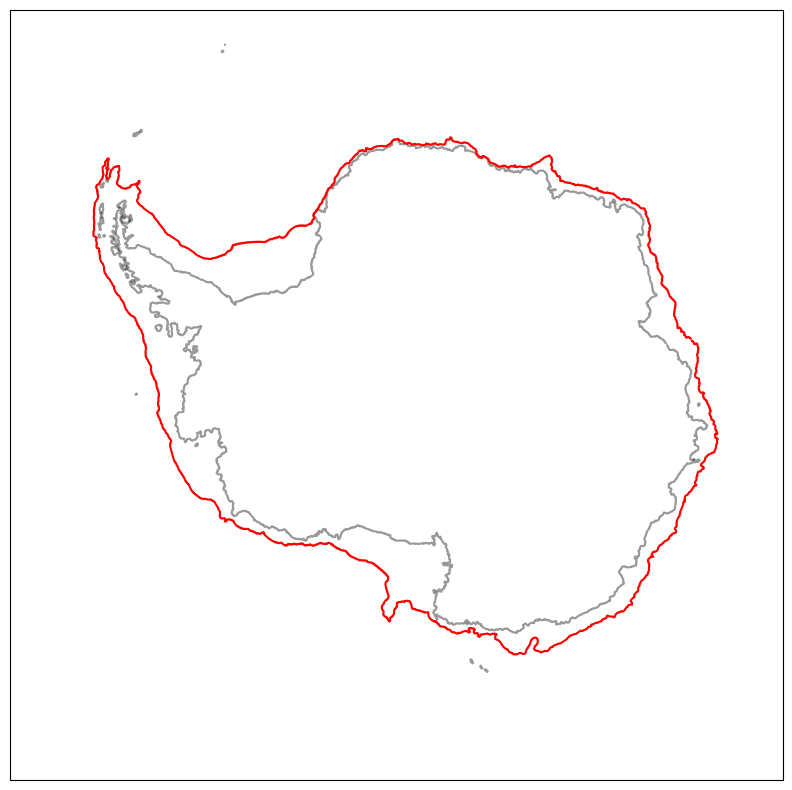

In [7]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


## Plot vertically integrated quantities

In [50]:
# set times to be last 5 years of 20 year perturbation

start_time = '2165-01-01'
end_time = '2169-12-31'

In [51]:
sfc_salt_flux_restore_basal = cc.querying.getvar(basal,'sfc_salt_flux_restore', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_restore_basal = sfc_salt_flux_restore_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_restore_basal = (sfc_salt_flux_restore_basal*sfc_salt_flux_restore_basal.time.dt.days_in_month).sum('time')/sfc_salt_flux_restore_basal.time.dt.days_in_month.sum('time')
sfc_salt_flux_restore_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_restore_basal)

sfc_salt_flux_restore_control = cc.querying.getvar(control,'sfc_salt_flux_restore', master_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_restore_control = sfc_salt_flux_restore_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_restore_control = (sfc_salt_flux_restore_control*sfc_salt_flux_restore_control.time.dt.days_in_month).sum('time')/sfc_salt_flux_restore_control.time.dt.days_in_month.sum('time')
sfc_salt_flux_restore_control_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_restore_control)

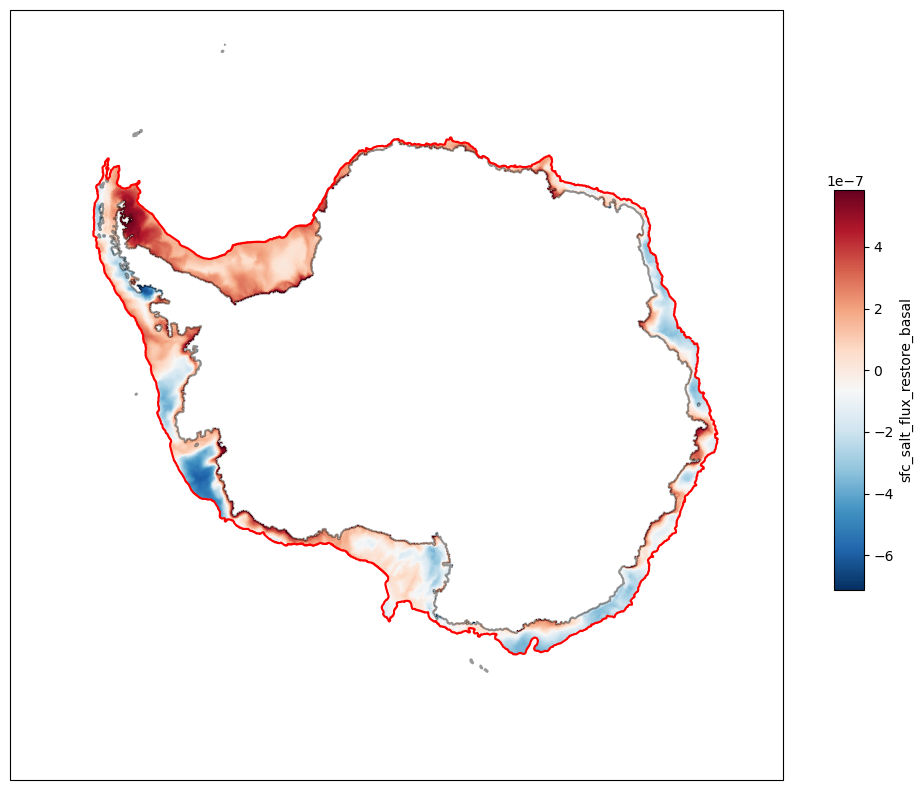

In [52]:

fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_salt_flux_restore_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r')
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_restore_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


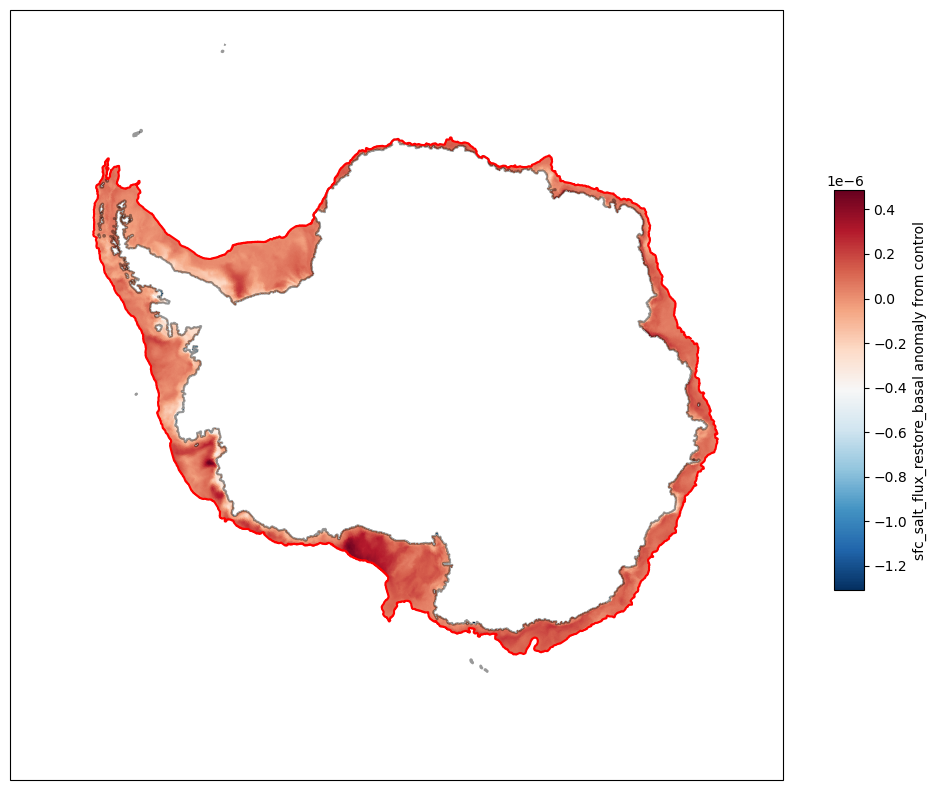

In [53]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_salt_flux_restore_basal_shelf-sfc_salt_flux_restore_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r')
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_restore_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [54]:
sfc_salt_flux_ice_basal = cc.querying.getvar(basal,'sfc_salt_flux_ice', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_ice_basal = sfc_salt_flux_ice_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_ice_basal = (sfc_salt_flux_ice_basal*sfc_salt_flux_ice_basal.time.dt.days_in_month).sum('time')/sfc_salt_flux_ice_basal.time.dt.days_in_month.sum('time')
sfc_salt_flux_ice_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_ice_basal)

sfc_salt_flux_ice_control = cc.querying.getvar(control,'sfc_salt_flux_ice', master_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_ice_control = sfc_salt_flux_ice_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_ice_control = (sfc_salt_flux_ice_control*sfc_salt_flux_ice_control.time.dt.days_in_month).sum('time')/sfc_salt_flux_ice_control.time.dt.days_in_month.sum('time')
sfc_salt_flux_ice_control_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_ice_control)



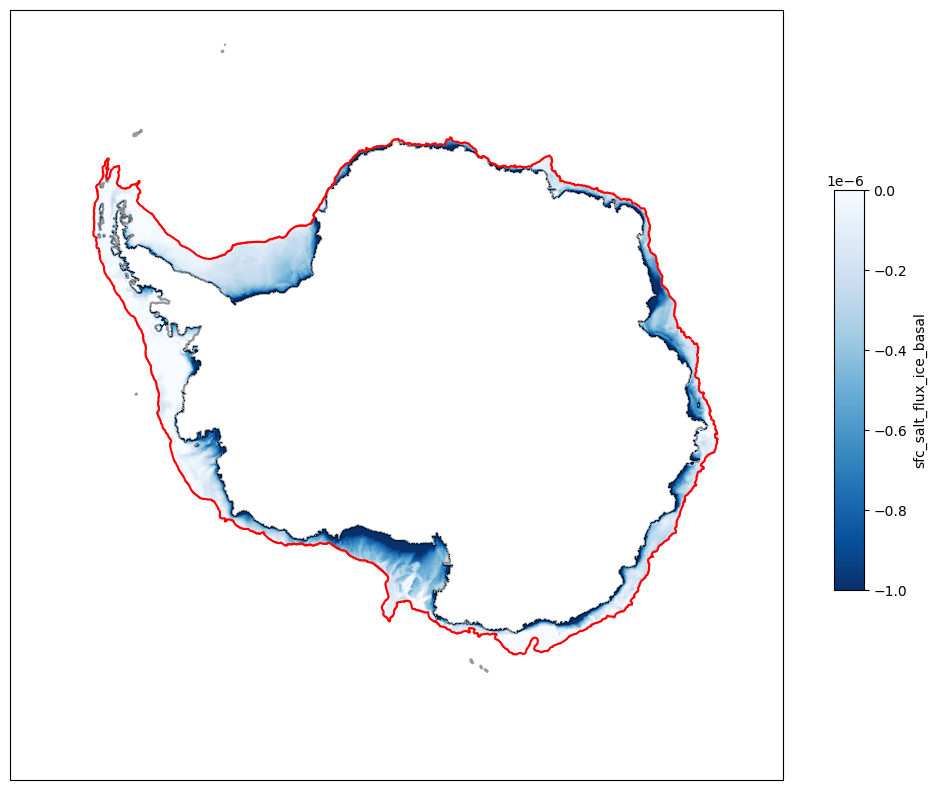

In [55]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_salt_flux_ice_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues_r', vmax = 0, vmin = -1e-6)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_ice_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


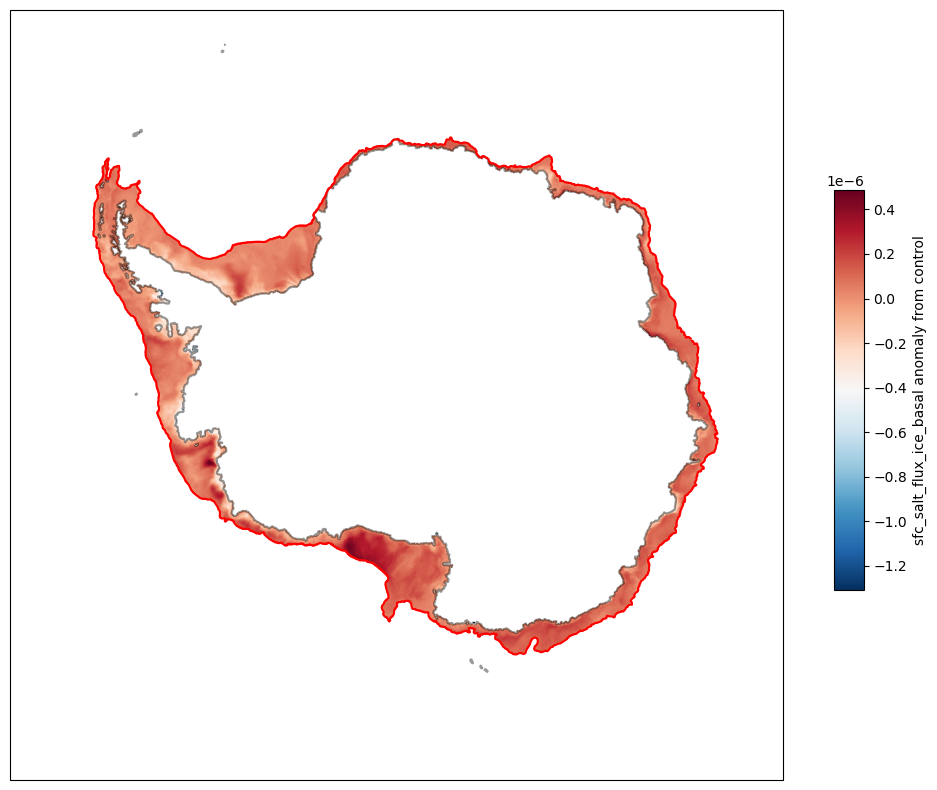

In [56]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_salt_flux_restore_basal_shelf-sfc_salt_flux_restore_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r')
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_ice_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [57]:

sfc_hflux_from_runoff_basal = cc.querying.getvar(basal,'sfc_hflux_from_runoff', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time, ncfile = 'ocean_month.nc') 
sfc_hflux_from_runoff_basal = sfc_hflux_from_runoff_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_from_runoff_basal = (sfc_hflux_from_runoff_basal*sfc_hflux_from_runoff_basal.time.dt.days_in_month).sum('time')/sfc_hflux_from_runoff_basal.time.dt.days_in_month.sum('time')
sfc_hflux_from_runoff_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_from_runoff_basal)

sfc_hflux_from_runoff_control = cc.querying.getvar(control,'sfc_hflux_from_runoff', master_session, 
                                                 start_time = start_time, end_time = end_time , ncfile = 'ocean_month.nc') 
sfc_hflux_from_runoff_control = sfc_hflux_from_runoff_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_from_runoff_control = (sfc_hflux_from_runoff_control*sfc_hflux_from_runoff_control.time.dt.days_in_month).sum('time')/sfc_hflux_from_runoff_control.time.dt.days_in_month.sum('time')
sfc_hflux_from_runoff_control_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_from_runoff_control)



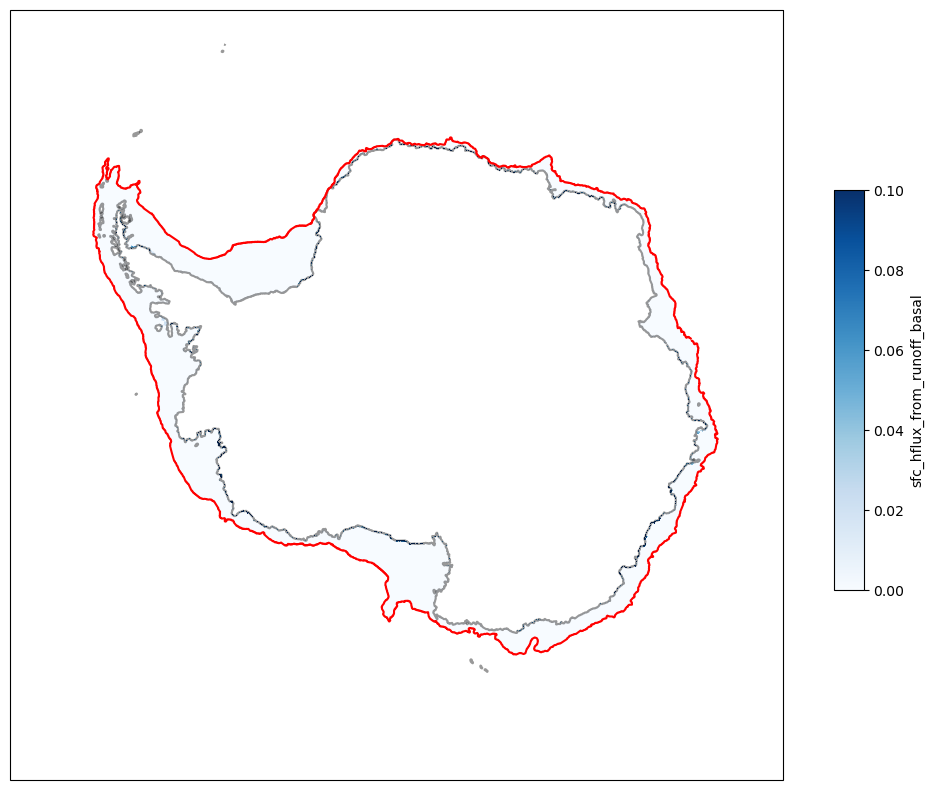

In [58]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_hflux_from_runoff_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues', vmin = 0, vmax = 0.1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_from_runoff_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


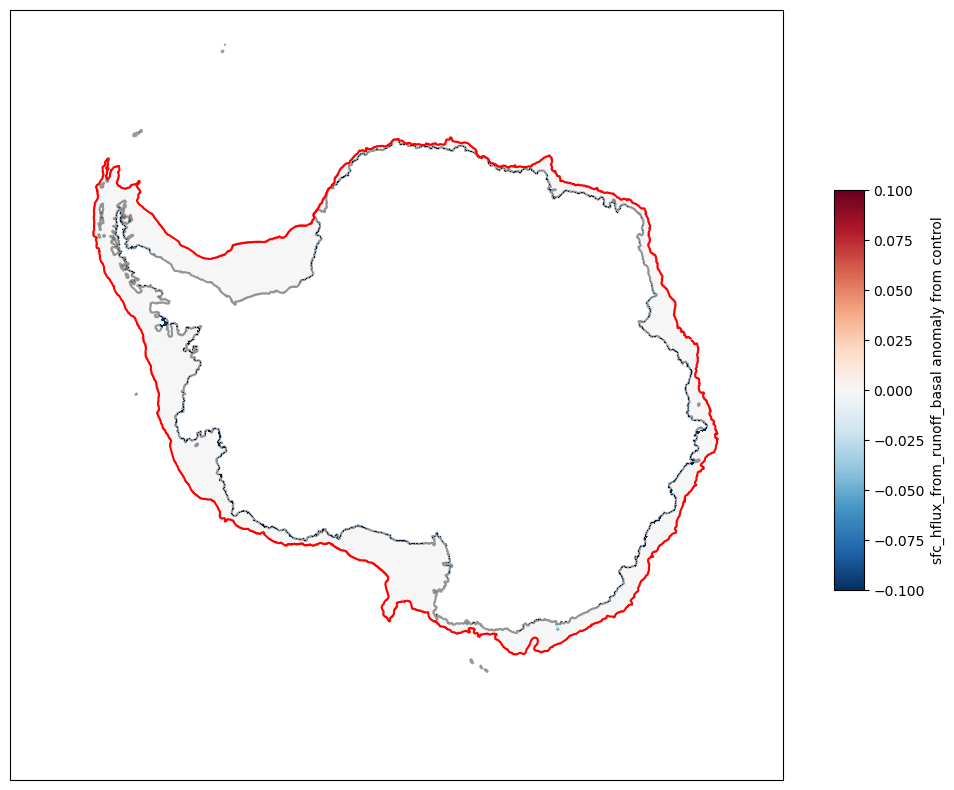

In [59]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_hflux_from_runoff_basal_shelf-sfc_hflux_from_runoff_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r', vmin = -0.1, vmax = 0.1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_from_runoff_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [60]:
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

print('control sfc_hflux_from_runoff = '+str((sfc_hflux_from_runoff_control_shelf*area).sum().values))

print('basal   sfc_hflux_from_runoff = '+str((sfc_hflux_from_runoff_basal_shelf*area).sum().values))


control sfc_hflux_from_runoff = 55120206551.080574
basal   sfc_hflux_from_runoff = 10190166788.806711


In [61]:

sfc_hflux_pme_basal = cc.querying.getvar(basal,'sfc_hflux_pme', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time, ncfile = 'ocean_month.nc') 
sfc_hflux_pme_basal = sfc_hflux_pme_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_pme_basal = (sfc_hflux_pme_basal*sfc_hflux_pme_basal.time.dt.days_in_month).sum('time')/sfc_hflux_pme_basal.time.dt.days_in_month.sum('time')
sfc_hflux_pme_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_pme_basal)

sfc_hflux_pme_control = cc.querying.getvar(control,'sfc_hflux_pme', master_session, 
                                                 start_time = start_time, end_time = end_time , ncfile = 'ocean_month.nc') 
sfc_hflux_pme_control = sfc_hflux_pme_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_pme_control = (sfc_hflux_pme_control*sfc_hflux_pme_control.time.dt.days_in_month).sum('time')/sfc_hflux_pme_control.time.dt.days_in_month.sum('time')
sfc_hflux_pme_control_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_pme_control)



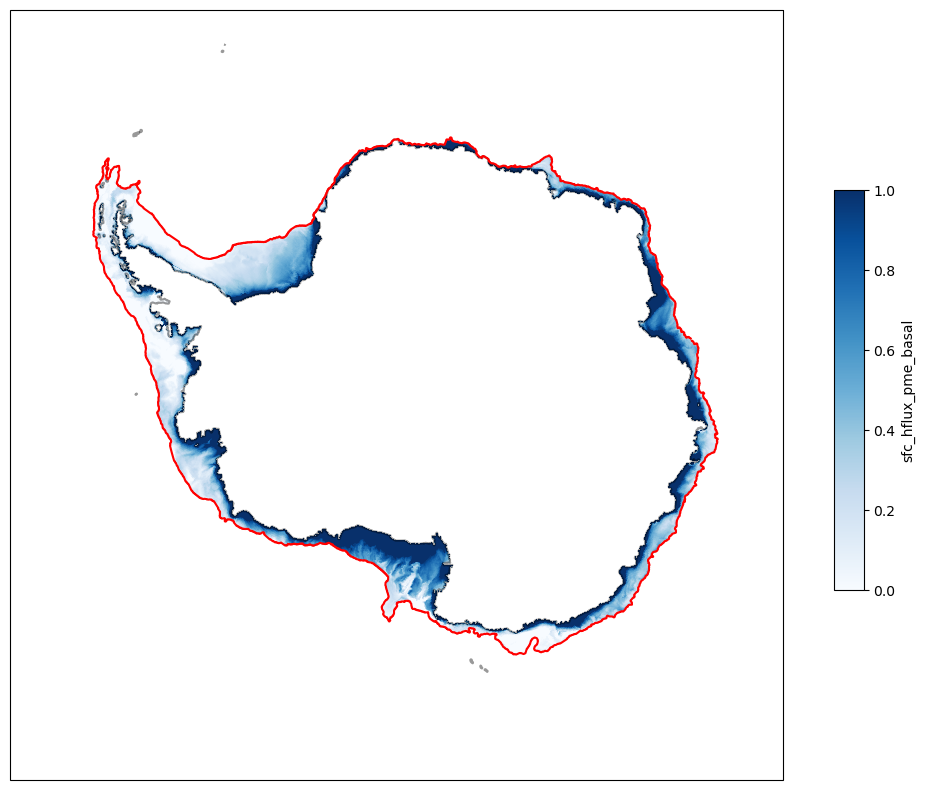

In [62]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_hflux_pme_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues', vmin = 0, vmax = 1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_pme_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


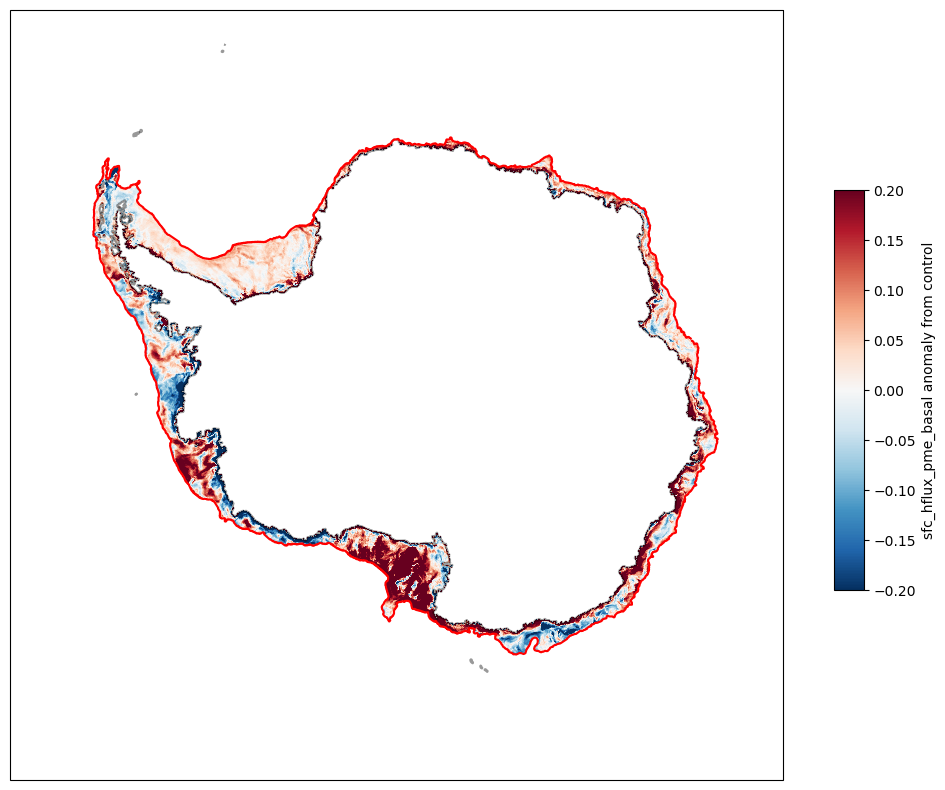

In [63]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_hflux_pme_basal_shelf-sfc_hflux_pme_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_pme_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [64]:
frazil_3d_int_z_basal = cc.querying.getvar(basal,'frazil_3d_int_z', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time, ncfile = 'ocean_month.nc') 
frazil_3d_int_z_basal = frazil_3d_int_z_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
frazil_3d_int_z_basal = (frazil_3d_int_z_basal*frazil_3d_int_z_basal.time.dt.days_in_month).sum('time')/frazil_3d_int_z_basal.time.dt.days_in_month.sum('time')
frazil_3d_int_z_basal_shelf, shelf_mask = shelf_mask_isobath(frazil_3d_int_z_basal)

frazil_3d_int_z_control = cc.querying.getvar(control,'frazil_3d_int_z', master_session, 
                                                 start_time = start_time, end_time = end_time , ncfile = 'ocean_month.nc') 
frazil_3d_int_z_control = frazil_3d_int_z_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
frazil_3d_int_z_control = (frazil_3d_int_z_control*frazil_3d_int_z_control.time.dt.days_in_month).sum('time')/frazil_3d_int_z_control.time.dt.days_in_month.sum('time')
frazil_3d_int_z_control_shelf, shelf_mask = shelf_mask_isobath(frazil_3d_int_z_control)



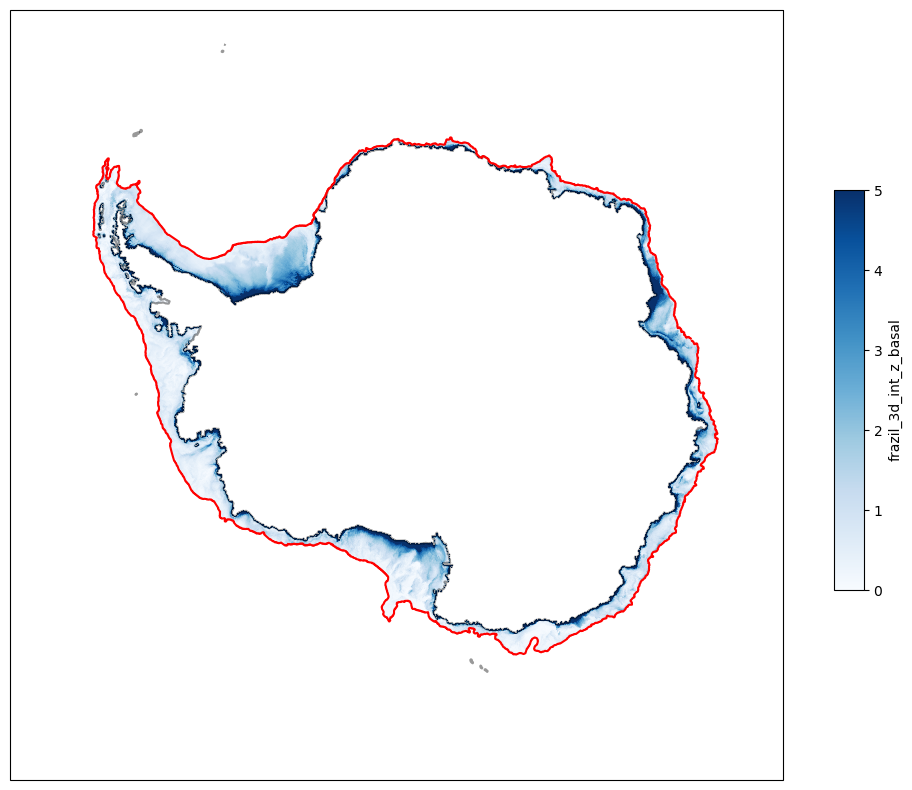

In [65]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, frazil_3d_int_z_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues', vmin = 0, vmax = 5)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'frazil_3d_int_z_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


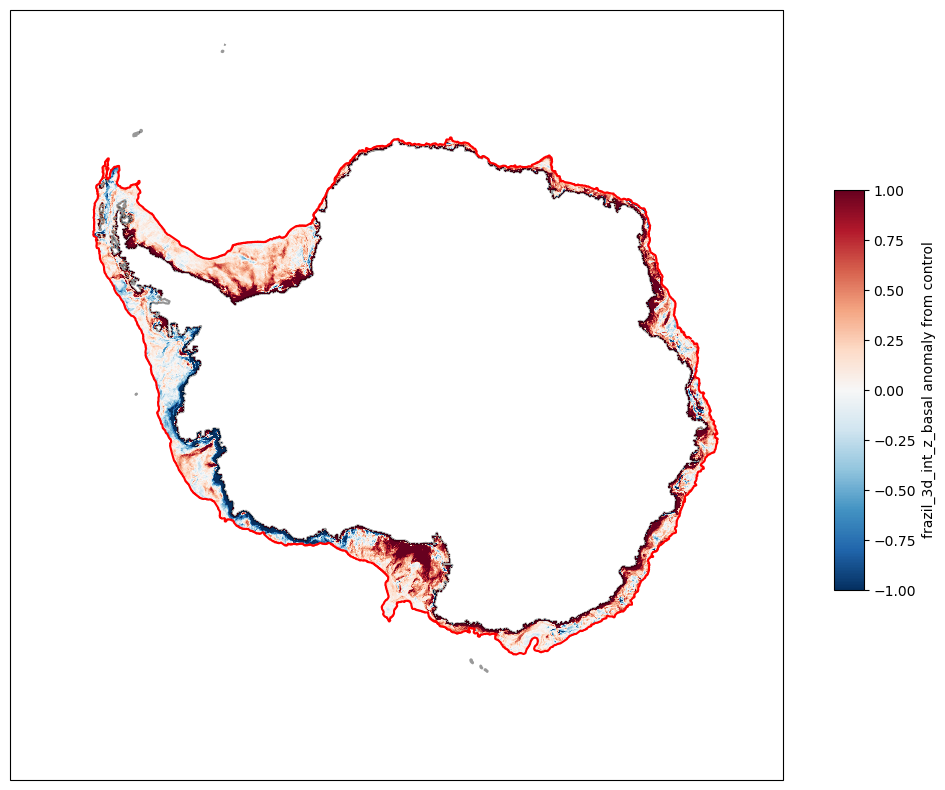

In [66]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (frazil_3d_int_z_basal_shelf-frazil_3d_int_z_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r', vmin = -1, vmax = 1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'frazil_3d_int_z_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
